In [1]:
import time

import matplotlib.pyplot as plt
import nltk
import torch
import torch.nn as nn
import torch.optim as optim
import wikipediaapi

In [2]:
wiki = wikipediaapi.Wikipedia(user_agent="waynestalk/1.0", language="en")
page = wiki.page("Oolong")
corpus = page.text

nltk.download("punkt")
sentences = nltk.sent_tokenize(corpus)
tokenized_corpus = [[word.lower() for word in nltk.word_tokenize(sentence) if word.isalpha()] for sentence in sentences]
tokenized_corpus[:5]

[nltk_data] Downloading package punkt to /Users/wayne/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


[['oolong',
  'uk',
  'us',
  'simplified',
  'chinese',
  '乌龙茶',
  'traditional',
  'chinese',
  '烏龍茶',
  'pinyin',
  'wūlóngchá',
  'tê',
  'black',
  'dragon',
  'tea',
  'is',
  'a',
  'traditional',
  'chinese',
  'tea',
  'camellia',
  'sinensis',
  'produced',
  'through',
  'a',
  'process',
  'that',
  'includes',
  'withering',
  'the',
  'leaves',
  'under',
  'strong',
  'sun',
  'and',
  'allowing',
  'some',
  'oxidation',
  'to',
  'occur',
  'before',
  'curling',
  'and',
  'twisting'],
 ['most',
  'oolong',
  'teas',
  'especially',
  'those',
  'of',
  'fine',
  'quality',
  'involve',
  'unique',
  'tea',
  'plant',
  'cultivars',
  'that',
  'are',
  'exclusively',
  'used',
  'for',
  'particular',
  'varieties'],
 ['the',
  'degree',
  'of',
  'oxidation',
  'which',
  'is',
  'controlled',
  'by',
  'the',
  'length',
  'of',
  'time',
  'between',
  'picking',
  'and',
  'final',
  'drying',
  'can',
  'range',
  'from',
  'to',
  'depending',
  'on',
  'the',


In [3]:
vocab = set([word for sentence in tokenized_corpus for word in sentence])
word_to_index = {word: i for i, word in enumerate(vocab)}
index_to_word = {i: word for i, word in enumerate(vocab)}
len(vocab)


580

In [4]:
window_size = 2
training_pairs = []

for sentence in tokenized_corpus:
    for i, target_word in enumerate(sentence):
        context_indices = (list(range(max(i - window_size, 0), i)) +
                           list(range(i + 1, min(i + window_size + 1, len(sentence)))))
        for context_index in context_indices:
            training_pairs.append((target_word, sentence[context_index]))
training_pairs[:5]

[('oolong', 'uk'),
 ('oolong', 'us'),
 ('uk', 'oolong'),
 ('uk', 'us'),
 ('uk', 'simplified')]

In [5]:
class SkipGram(nn.Module):
    def __init__(self, vocab_size, embedding_dim):
        super(SkipGram, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.linear = nn.Linear(embedding_dim, vocab_size)

    def forward(self, word):
        vector = self.embedding(word)
        return self.linear(vector)

In [6]:
model = SkipGram(len(vocab), 1000)

loss_function = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)
epochs = 500

start_time = time.time()

for epoch in range(epochs):
    total_loss = 0
    for target, context in training_pairs:
        target_tensor = torch.tensor([word_to_index[target]], dtype=torch.long)
        context_tensor = torch.tensor([word_to_index[context]], dtype=torch.long)
        output = model(target_tensor)
        loss = loss_function(output, context_tensor)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    if epoch == 0 or (epoch + 1) % 100 == 0:
        print(f"Epoch: {epoch}, Loss: {total_loss}")

end_time = time.time()
print(f"Training time: {end_time - start_time} seconds")

Epoch: 0, Loss: 53005.44864411908
Epoch: 99, Loss: 39075.894928383
Epoch: 199, Loss: 34225.59938139503
Epoch: 299, Loss: 31129.25231407117
Epoch: 399, Loss: 28878.19602577458
Epoch: 499, Loss: 27134.22448317823
Training time: 1395.594395160675 seconds


In [7]:
word = "oolong"
word_index_tensor = torch.tensor(word_to_index[word], dtype=torch.long)
embedding_vector = model.embedding(word_index_tensor).detach().numpy()
print(f"Embedding {embedding_vector.shape} for '{word}': {embedding_vector}")

Embedding (1000,) for 'oolong': [ 0.14162989  0.45162517 -0.20924519  0.2400067   0.04014093 -0.0422206
  0.1377291  -0.08605171 -0.27772245 -0.36740732  0.217593   -0.11250918
  0.03428505  0.10354972 -0.00295025 -0.19782603 -0.14894088  0.13014352
  0.04749083  0.19259764 -0.123813   -0.13824084 -0.06794284 -0.3238008
 -0.00237572  0.07355004  0.10450228 -0.01023001  0.00117357 -0.22091627
  0.15411937 -0.13354376  0.25526184 -0.1102496   0.067228   -0.08288954
 -0.03695459 -0.02026368  0.29726082  0.07766842 -0.29256263 -0.01205344
  0.20130825 -0.08113147 -0.12809014 -0.23803234 -0.05932997 -0.06295176
 -0.1542423   0.20005193 -0.12462249  0.18381152  0.15632595  0.06795065
 -0.02519018 -0.18918027  0.33341473  0.38222387 -0.31339812  0.14031735
 -0.137569   -0.08343355 -0.00868636 -0.0187066   0.06114349 -0.10331477
 -0.23055555  0.06730623  0.07411459  0.04881903 -0.16886245 -0.11102316
  0.07930106  0.02793908 -0.06532778  0.10005125 -0.14994922  0.1380028
 -0.09647068  0.015721

In [8]:
sentence1 = "tea is popular in taiwan".split()
sentence2 = "oolong is famous in taiwan".split()
sentence1_embeddings = [model.embedding(torch.tensor(word_to_index[word], dtype=torch.long)).detach() for word in sentence1]
sentence2_embeddings = [model.embedding(torch.tensor(word_to_index[word], dtype=torch.long)).detach() for word in sentence2]
vector1 = torch.stack(sentence1_embeddings).mean(dim=0)
vector2 = torch.stack(sentence2_embeddings).mean(dim=0)
cosine_sim = nn.CosineSimilarity(dim=0)
similarity = cosine_sim(vector1, vector2).item()
print(f"Sentence 1: {sentence1}")
print(f"Sentence 2: {sentence2}")
print(f"Similarity between sentences: {similarity}")

Sentence 1: ['tea', 'is', 'popular', 'in', 'taiwan']
Sentence 2: ['oolong', 'is', 'famous', 'in', 'taiwan']
Similarity between sentences: 0.35018718242645264


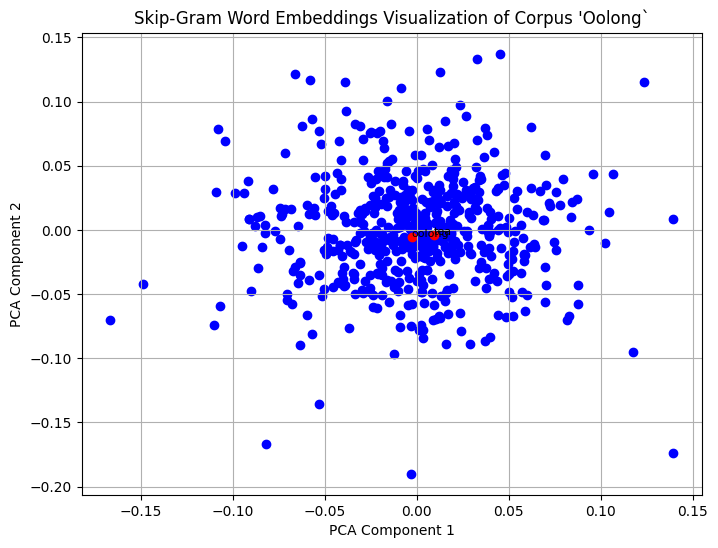

In [9]:
word_embeddings_tensor = model.embedding.weight.detach()
U, S, V = torch.pca_lowrank(word_embeddings_tensor, q=2)
reduced_embeddings = U.numpy()

plt.figure(figsize=(8, 6))

for word, index in word_to_index.items():
    x, y = reduced_embeddings[index]
    plt.scatter(x, y, marker='o', color='blue')

tea_index = word_to_index['tea']
x, y = reduced_embeddings[tea_index]
plt.scatter(x, y, marker='o', color='red')
plt.text(x, y, 'tea', fontsize=8)

oolong_index = word_to_index['oolong']
x, y = reduced_embeddings[oolong_index]
plt.scatter(x, y, marker='o', color='red')
plt.text(x, y, 'oolong', fontsize=8)

plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.title("Skip-Gram Word Embeddings Visualization of Corpus 'Oolong`")
plt.grid(True)
plt.show()